# Heart Disease UCI

## features
1. age
2. sex
3. chest pain type (4 values): 
   - Value 0: asymptomatic
   - Value 1: atypical angina
   - Value 2: pain without relation to angina
   - Value 3: typical angina
4. resting blood pressure: Resting blood pressure in millimeters of mercury (mm Hg) 
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2):
    - Value 0: probable left ventricular hypertrophy
    - Value 1: normal
    - Value 2: abnormalities in the T wave or ST segment
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
    - Value 0: descending
    - Value 1: flat
    - Value 2: ascending
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve


# Loading data

In [4]:
data=pd.read_csv('prep_data.csv') # loading preprocessed data
data = data.iloc[:, 1:]

In [7]:
data.head()

,Age,Resting_Blood_Pressure,Colestrol,Fasting_Blood_Sugar,MAX_Heart_Rate,Exercised_Induced_Angina,ST_Depression,Major_Vessels,Target,Chest_Pain_1,...,Rest_ECG_0,Rest_ECG_1,Rest_ECG_2,Thalessemia_3,Thalessemia_6,Thalessemia_7,Slope_1,Slope_2,Slope_3,target_bin
0,0.708333,0.75,-0.153846,1.0,-0.090909,0.0,0.9375,0,0,1,...,0,0,1,0,1,0,0,0,1,0
1,0.791667,1.50,0.661538,0.0,-1.363636,1.0,0.4375,3,2,0,...,0,0,1,1,0,0,0,1,0,1
2,0.791667,-0.50,-0.215385,0.0,-0.727273,1.0,1.1250,2,1,0,...,0,0,1,0,0,1,0,1,0,1
3,0.166667,0.00,0.107692,0.0,1.030303,0.0,1.6875,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,0.250000,0.00,-0.600000,0.0,0.575758,0.0,0.3750,0,0,0,...,0,0,1,1,0,0,1,0,0,0


## Split into train test set

In [8]:
# Split into training set and testing set
def split_data(data, target, test_size=0.2, random_seed=42, stratify=True):
    X = data.drop(['target_bin', 'Target'], axis=1)
    y = data[target]
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=y.values,
                                                            random_state=random_seed,
                                                            shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=test_size,
                                                            stratify=None,
                                                            random_state=random_seed,
                                                            shuffle=True)
        
    return X_train, X_test, y_train, y_test

In [9]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = split_data(data, target='target_bin')
X_train, X_test, y_train, y_test = split_data(data, target='Target')

# Metric for measuring performance: Confusion matrix

In [10]:
def confusion_matrix_display(ytrue, ypred, cmap='Greens', classifier=''):
    cf_matrix = confusion_matrix(ytrue, ypred)
    if len(np.unique(ytrue)) == 2:
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(ypred)): 
            if ytrue[i]==ypred[i]==1:
                TP += 1
            if ypred[i]==1 and ytrue[i]!=ypred[i]:
                FP += 1
            if ytrue[i]==ypred[i]==0:
                TN += 1
            if ypred[i]==0 and ytrue[i]!=ypred[i]:
                FN += 1
    
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN) if TP+FN!=0 else 0
        # Specificity or true negative rate
        TNR = TN/(TN+FP) if TN+FP!=0 else 0
        # Precision or positive predictive value
        PPV = TP/(TP+FP) if TP+FP!=0 else 0
        # Negative predictive value
        NPV = TN/(TN+FN) if TN+FN!=0 else 0
        # Fall out or false positive rate
        FPR = FP/(FP+TN) if FP+TN!=0 else 0
        # False negative rate
        FNR = FN/(TP+FN) if TP+FN!=0 else 0
        # False discovery rate
        FDR = FP/(TP+FP) if TP+FP!=0 else 0
        # Overall accuracy
        print('TPR,FPR, TNR, FNR = {:.3f},{:.3f},{:.3f},{:.3f}'.format(TPR, FPR, TNR, FNR))
        print('Precision = {:.3f}'.format(PPV))
    ACC = np.mean(ytrue == ypred)
    fig, ax=plt.subplots(1,1, figsize=(8,8))
    ax = sns.heatmap(cf_matrix, annot=True, cmap=cmap, ax=ax)
    ax.set_xlabel('Predict')
    ax.set_ylabel('True')
    ax.set_title('Confusion matrix:' + classifier )
    
    print('Accuracy:', ACC)

    return ACC, cf_matrix

# Multi-Classification for imbalanced data

Accuracy: 0.5666666666666667


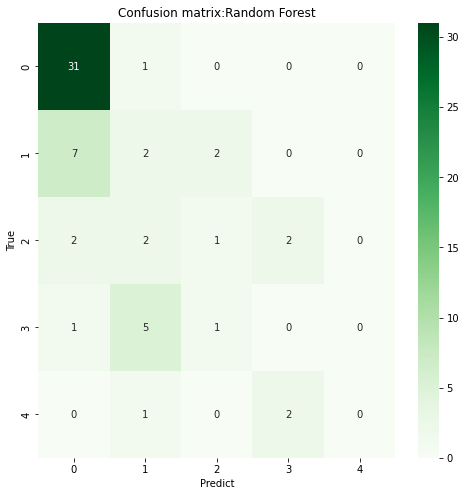

In [16]:
model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train)
pred = model.predict(X_test)
a = confusion_matrix_display(y_test.values, pred, classifier='Random Forest')

Accuracy: 1.0


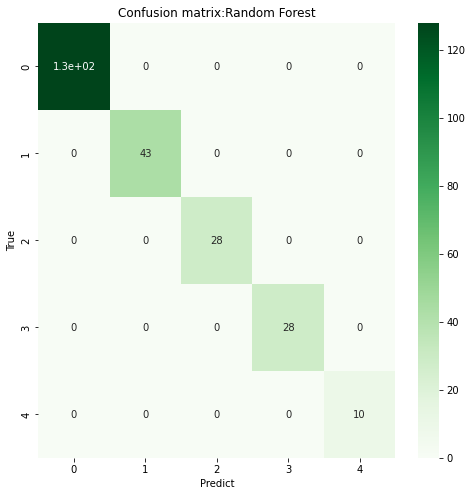

In [17]:
pred = model.predict(X_train)
a = confusion_matrix_display(y_train.values, pred, classifier='Random Forest')

- **The model can well classify training set but not test set.**
- But can well predict non-heart disease sample.

## PCA Analysis

In [18]:
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from sklearn.decomposition import PCA

Text(0, 0.5, 'PC 2')

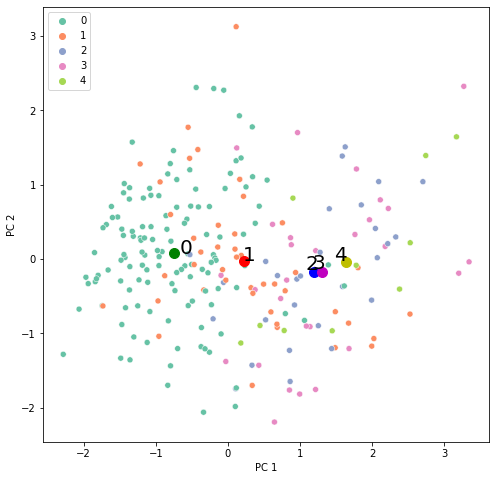

In [19]:
pca = PCA(n_components=5)
x_train_emb = pca.fit_transform(X_train)
f = plt.figure(figsize=(8,8))
ax=sns.scatterplot(x=x_train_emb[:, 0], y=x_train_emb[:, 1], hue=y_train.values, palette='Set2')
ax.scatter(x=x_train_emb[y_train==0, 0].mean(),y=x_train_emb[y_train==0, 1].mean(),c='green', s=100)
ax.scatter(x=x_train_emb[y_train==1, 0].mean(),y=x_train_emb[y_train==1, 1].mean(),c='red', s=100)
ax.scatter(x=x_train_emb[y_train==2, 0].mean(),y=x_train_emb[y_train==2, 1].mean(),c='b', s=100)
ax.scatter(x=x_train_emb[y_train==3, 0].mean(),y=x_train_emb[y_train==3, 1].mean(),c='m', s=100)
ax.scatter(x=x_train_emb[y_train==4, 0].mean(),y=x_train_emb[y_train==4, 1].mean(),c='y', s=100)
for i in range(5):
    x = x_train_emb[y_train==i, 0].mean()*0.9
    y = x_train_emb[y_train==i, 1].mean()*0.8
    ax.annotate(str(i),xy=(x,y),size=20)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

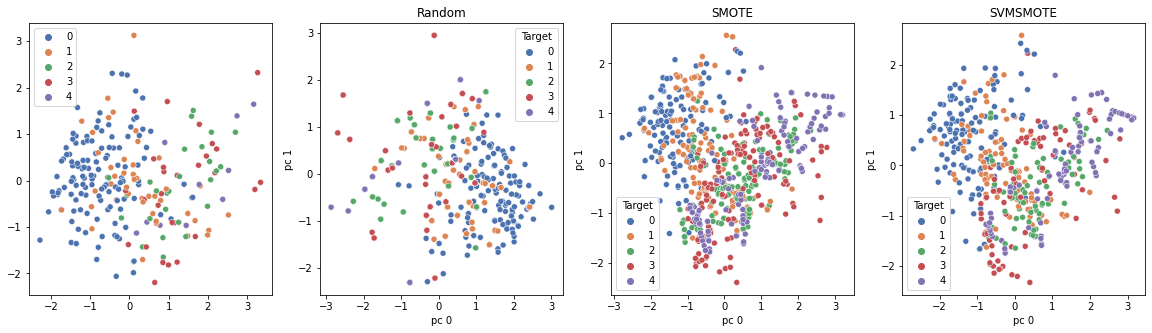

In [20]:
oversampler = [RandomOverSampler(), SMOTE(), SVMSMOTE()]
names = ['original','Random', 'SMOTE', 'SVMSMOTE']
f, axes = plt.subplots(1, 4, figsize=(20, 5))
pca = PCA(n_components=2)
ax=sns.scatterplot(x=x_train_emb[:, 0], y=x_train_emb[:, 1], hue=y_train.values, palette="deep", ax = axes[0])
for i, os in enumerate(oversampler, 1):
    x, y = os.fit_resample(X_train, y_train)
    x_emb = pca.fit_transform(x)
    ax = sns.scatterplot(x=x_emb[:, 0], y=x_emb[:, 1], hue=y, palette="deep", ax=axes[i])
    ax.set_title(names[i])
    ax.set_xlabel('pc 0')
    ax.set_ylabel('pc 1')

Accuracy: 0.5333333333333333


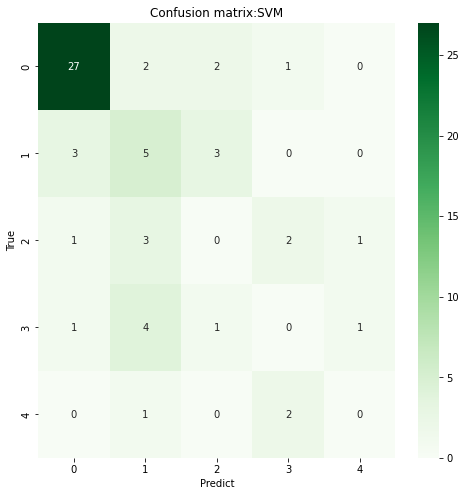

In [26]:
os = SVMSMOTE()
x, y = os.fit_resample(X_train, y_train)
model = SVC(C=5, kernel='poly', degree=5, class_weight={0:0.2, 1:0.3, 2:0.9, 3:0.8, 4:1.6})
model.fit(x, y)
pred = model.predict(X_test)
a = confusion_matrix_display(y_test.values, pred, classifier='SVM')

In [28]:
# to classify non-zero target is more difficult, focus only on samples with non-zero target
X_train_non_0 = X_train[y_train > 0]
y_train_non_0 = y_train[y_train > 0]
X_test_non_0 = X_test[y_test > 0]
y_test_non_0 = y_test[y_test > 0]

Accuracy: 0.32142857142857145


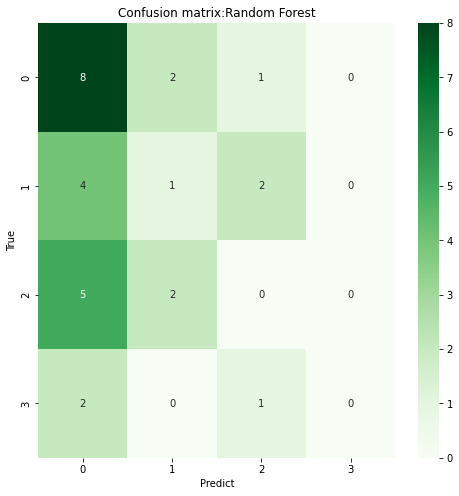

In [29]:
model = RandomForestClassifier(n_estimators=500, class_weight={1:0.1, 2:0.3, 3:0.7, 4:1})
model.fit(X_train_non_0, y_train_non_0)
pred = model.predict(X_test_non_0)
a = confusion_matrix_display(y_test_non_0.values, pred, classifier='Random Forest')

Text(0.5, 0, 'Importance')

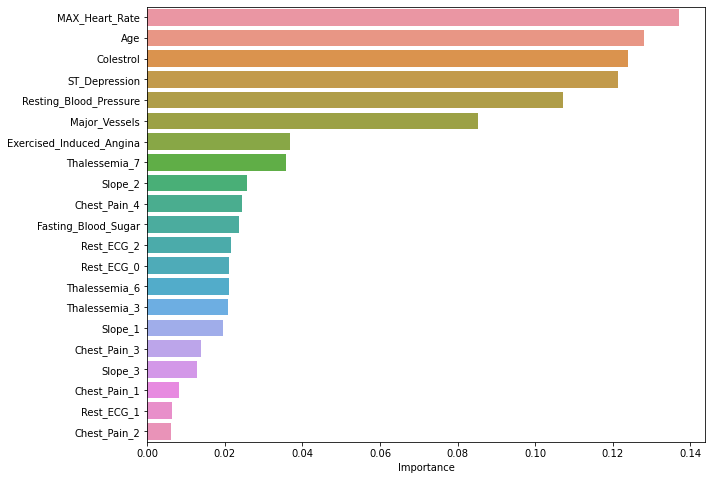

In [30]:
# importances of features
fig = plt.figure(figsize=(10, 8))
features_name = X_train_non_0.columns[np.argsort(model.feature_importances_)[::-1]]
ax = sns.barplot(y=features_name, x=np.sort(model.feature_importances_)[::-1], orient='h')
ax.set_xlabel('Importance')

In [39]:
# Feature selection
features_non_zero = features_name[:8]

Accuracy: 0.4642857142857143


(0.4642857142857143,
 array([[8, 2, 1, 0],
        [3, 1, 0, 3],
        [0, 2, 3, 2],
        [0, 1, 1, 1]]))

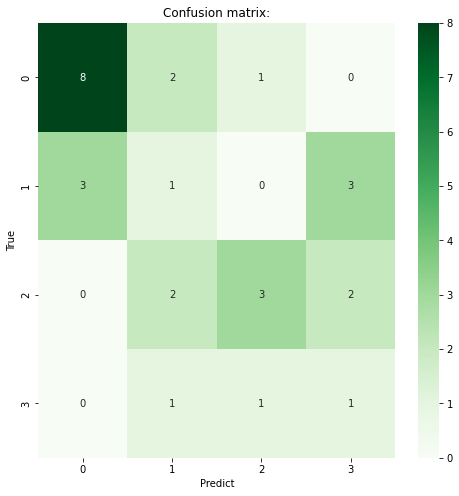

In [40]:
svm_ovo = SVC(C=2, kernel='linear', decision_function_shape='ovo', class_weight={1:0.5, 2:0.8, 3:0.6, 4:2},
             probability=True)
svm_ovo.fit(X_train[features_non_zero][y_train>0], y_train[y_train>0])
svm_ovo_pred = svm_ovo.predict(X_test[features_non_zero][y_test>0])
confusion_matrix_display(y_test[y_test>0].values, svm_ovo_pred)

# DNN with FOCAL Loss

In [47]:
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch import nn
import numpy as np
import torch.optim as optim

In [48]:
class MLP(nn.Module):
    def __init__(self, input_channels, output_channels, num_hidden_layers=3):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.layers = [nn.Linear(input_channels, 64)]
        for l in range(num_hidden_layers):
            self.layers.append(nn.Linear(64, 64))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(64, output_channels))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x).float()
    
    def predict(self, x):
        with torch.no_grad():
            ypred = self.layers(x)
            if self.output_channels>1:
                ypred = F.softmax(ypred, dim=1).argmax(dim=-1) + 1
            else:
                ypred = (torch.sigmoid(ypred) > 0.5).float()
        return ypred

In [49]:
#ref: https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py

def focal_loss(input_tensor, target_tensor, gamma=1, alpha=None):
    input_soft = F.softmax(input_tensor, dim=1)
    log_input_soft = F.log_softmax(input_tensor, dim=1)
    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)
    if alpha is None:
        alpha = torch.ones_like(weight)
    focal = -alpha * weight * log_input_soft

    loss = torch.einsum('bc...,bc...->b...', (target_tensor.to(torch.double), focal.to(torch.double)))

    return loss.mean().float()


def binary_focal_loss_with_logits(inputs, target, gamma=1, alpha=None):
    probs_pos = torch.sigmoid(inputs)
    probs_neg = torch.sigmoid(-inputs)
    if alpha is None:
        alpha = 0.5
    loss_tmp = -alpha * (probs_neg ** gamma) * target * F.logsigmoid(inputs) - \
    (1 - alpha) * (probs_pos ** gamma) * (1.0 - target) * F.logsigmoid(-inputs)
    return loss_tmp.mean()


In [50]:
# utils
def to_tensor(X, y, onehot=False, sample=None):
    tensor_x = torch.from_numpy(X.values).float()
    tensor_y = torch.from_numpy(y.values).float()
    if onehot:
        tensor_y_onehot = torch.from_numpy(one_hot_encoding(tensor_y.view(-1,1), sample=sample)).float()
        return tensor_x, tensor_y, tensor_y_onehot
    else:
        return tensor_x, tensor_y

def sampler(X, y, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True)
    return X_train, X_val, y_train, y_val


def score_estimator(X_train, classifier=svc):
    return classifier.predict_proba(pd.DataFrame(X_train, columns=features_non_zero))[:, 1]

def one_hot_encoding(inputs, sample=None):
    print(inputs.shape)
    if sample is None:
        sample=inputs
    onehot_encoder = OneHotEncoder()
    onehot_encoder.fit(sample)
    return onehot_encoder.transform(inputs).toarray()

In [53]:
# binary
from tqdm import tqdm
tensor_x, tensor_y, tensor_y_onehot = to_tensor(X_train_non_0[features_non_zero], 
                                                y_train_non_0, 
                                                onehot=True)

tensor_x_test, tensor_y_test, tensor_y_test_onehot = to_tensor(X_test_non_0[features_non_zero],
                                                          y_test_non_0, 
                                                          onehot=True)

train_dataset = TensorDataset(tensor_x, tensor_y_onehot) # create your datset
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

torch.Size([109, 1])
torch.Size([28, 1])


In [55]:
n_epochs = 100
n_sampler = 30
criterion = nn.BCELoss()
y_u, y_c = np.unique(y_train_non_0, return_counts=True)

gamma = 1
mlps = []
optimizers = []
#for s in range(n_sampler):
mlp = MLP(input_channels=tensor_x.size()[1], output_channels=4, num_hidden_layers=10)
optimizer = optim.Adam(mlp.parameters(), lr=0.0005)
weights = torch.from_numpy(1 - y_c / y_c.sum()).view(1, -1)
#alpha = torch.from_numpy(weights).view(1, -1)
l_s = []
l_val_s = []
acc_s = []
acc_test_s = []

for s in range(n_sampler):
    tensor_x_input = tensor_x
    x_train, x_val, _y_train, _y_val = sampler(tensor_x_input, tensor_y_onehot, test_size=0.1)
    train_dataset = TensorDataset(x_train, _y_train) # create your datset
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    losses=[]
    losses_val = []
    accuracy_train = []
    accuracy_test = []
    #mlp = mlps[s]
    #optimizer = optimizers[s]
    for epoch in tqdm(range(n_epochs), desc='Sampler' + str(s+1)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, d in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = d
            # zero the parameter gradients
            alpha = weights.detach() + 0.5 - torch.from_numpy(np.abs(0.5 - score_estimator(inputs.detach().numpy(), 
                                                                classifier=svc_dnn))).view(-1, 1).detach() 
            optimizer.zero_grad()

            # forward + backward + optimize
            output = mlp(inputs)
            loss = focal_loss(output, labels, gamma=gamma, alpha=alpha)
            #loss = F.binary_cross_entropy(torch.sigmoid(output), labels.view(-1, 1), weight=alpha)
            loss.backward()
            optimizer.step()
        
            # print statistics
            running_loss += loss.item()
        losses.append(running_loss / (i + 1))
        running_loss = 0.0
        # validation
        with torch.no_grad():
            losses_val.append(focal_loss(mlp(x_val), _y_val, gamma=gamma, alpha=None))
        accuracy_train.append(np.mean(y_train_non_0.values == mlp.predict(tensor_x).detach().numpy()))
        accuracy_test.append(np.mean((_y_val.argmax(dim=-1)+1).detach().numpy() == \
                                     mlp.predict(x_val).detach().numpy()))

    l_s.append(losses)
    l_val_s.append(losses_val)
    acc_s.append(accuracy_train)
    acc_test_s.append(accuracy_test)
        
        

print('Finished Training')

Sampler30: 100%|██████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]

Finished Training


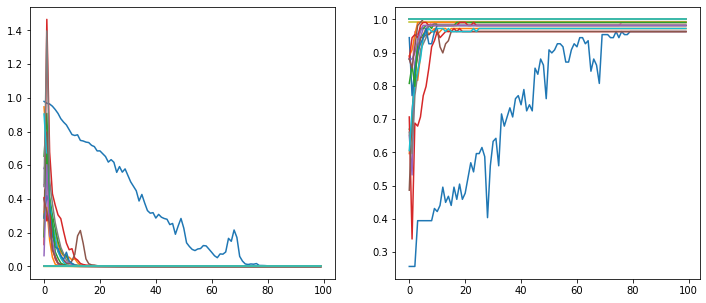

In [56]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax = axes[0]
a = ax.plot(np.asarray(l_s).T)
ax = axes[1]
a = ax.plot(np.asarray(acc_s).T)


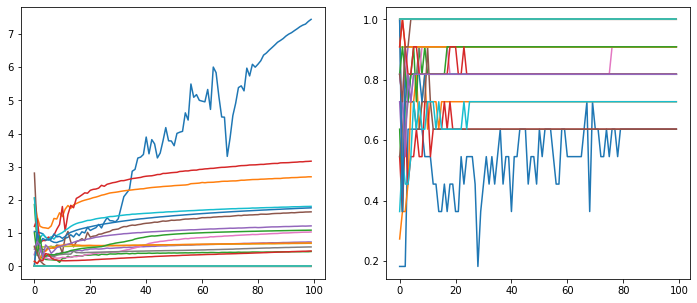

In [57]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax = axes[0]
a = ax.plot(np.asarray(l_val_s).T)
ax = axes[1]
a = ax.plot(np.asarray(acc_test_s).T)


Accuracy: 0.32142857142857145


(0.32142857142857145,
 array([[5, 2, 4, 0],
        [4, 2, 1, 0],
        [3, 2, 2, 0],
        [1, 1, 1, 0]]))

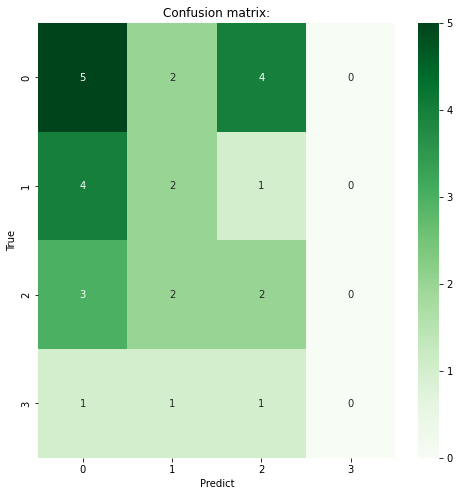

In [62]:
confusion_matrix_display(tensor_y_test.detach().numpy(), mlp.predict(tensor_x_test).detach().numpy())

Accuracy: 1.0


(1.0,
 array([[43,  0,  0,  0],
        [ 0, 28,  0,  0],
        [ 0,  0, 28,  0],
        [ 0,  0,  0, 10]]))

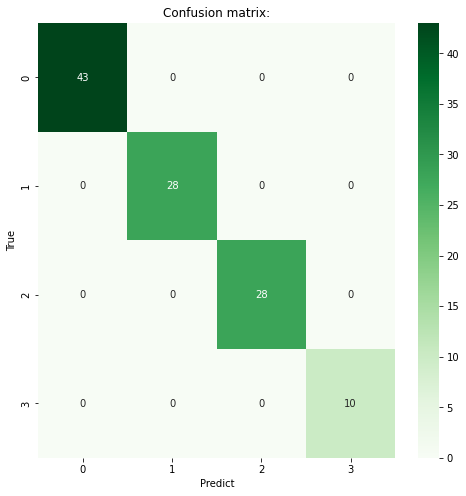

In [64]:
confusion_matrix_display(tensor_y.detach().numpy(), mlp.predict(tensor_x).detach().numpy())